In [22]:
import pandas as pd
import json, numpy as np
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import folium
from datetime import timedelta
import seaborn as sns #to make plots more aesthetic 
import matplotlib.dates as mdates  #used to space out the dates on the x-axis of plots

## Task 0 
Read in data, sanity checks and data processing

### Description of the given datasets 

#### Weather data 

The weather data contains information about the weather in Sweden, Germany, Netherlands and Denmark. We filter the dataset and create a data frame only containing information about Germany. 

The data set contains the following attributes: 

> **Date** YYYY-MM-DD format <br>
<br>
> **iso3166-2** Identifier for country and region <br>
<br>
> **RelativeHumiditySurface** Measure of relative water vapor in the air. Expressed in ratio - how much water vapor in the air compared to how much the air actually can contain.  <br>
<br>
> **SolarRadiation** Measurement of the intensity of the sun's radiation reaching a horizontal surface. Covers infrared, visible light, Ultraviolet light (UV), and other types of radiation. Unit: $W/m^{2}$ <br>
<br>
> **Surfacepressure** Measure of the pressure within the atmosphere of the earth. <br>
<br>
> **TemperatureAboveGround** Daily average of the temperature above ground. Unit $K$ later converted to $C^{\circ}$ <br>
<br>
> **Totalprecipitation** Total sum of the daily precipitation.<br>
<br>
> **UVIndex** Measure of sun-burning ultraviolet radiation <br>
<br>
> **Windspeed** Measure of wind speed.<br>
<br>

#### Corona data 
The corona dataset contains daily information about confirmed cases and number of deaths, grouped in regions. In the period: 2020-01-02 to 2021-02-21
<br>
The dataset contains the following attributes:
<br>
> **date** YYYY-MM-DD format <br>
<br>
> **region-code** The name of the state <br>
<br>
> **confirmed_addition** Daily sum of confirmed cases given regionally. <br>
<br>
> **deceased_addition** Daily sum of deaths given regionally. <br>

#### Metadata 
Information about the different regions. Contains the following:
> **iso3166-1_code** Country identifier <br>
<br>
> **iso3166-1_name** Name of country (in English) <br>
<br>
> **iso3166-2_code** Country and region identifier <br>
<br>
> **iso3166-2_name_en** Name of region <br>
<br>
> **population** Number of inhabitants in the given region <br>
<br>
> **covid_region_code** Region code given in the corona data set 

#### Geojson data
geojson file containing coordinates used for the map visualizations. Used for visualizing e.g. corona cases grouped by regions on the map. 

In [23]:
#filepaths
geojsonpath = "./data/shapefiles/de.geojson"
weatherpath = "./data/weather/weather.csv"
covpath = "./data/corona/de_corona.csv"
metapath = "./data//metadata/de_metadata.json"
oxfordpath = "OxCGRT_latest.csv"

In [24]:
# Read in weather_data
weather_data = pd.read_csv(weatherpath)

# check if there are missing values and sort weather data to only include germany
weather_data = weather_data[weather_data['iso3166-2'].str.startswith('DE')]
if weather_data.isna().any().any():
    raise ValueError('Missing values')

# check for duplicate values
for it in weather_data.duplicated():
    if it == True:
        raise ValueError('Duplicated values')

# change temperature from kelvin to celcius 
weather_data['TemperatureAboveGround'] = weather_data['TemperatureAboveGround'] - 273.15

# load in corona data 
corona_data = pd.read_csv(covpath, delimiter = '\t')

# check if there are missing values 
if corona_data.isna().any().any():
    raise ValueError('Missing values')

# check for duplicate values
for it in corona_data.duplicated():
    if it == True:
        raise ValueError('Duplicated values')

# check for negative values
for it in (corona_data.select_dtypes(include = 'number') < 0).any():
    if it == True:
        raise ValueError('Negative values')

# load in metadata 
with open(metapath, encoding = 'utf-8') as f:
    metadata = json.load(f)

# External data containing strigency index
oxford_data = pd.read_csv(oxfordpath, low_memory = False)
oxford_de = oxford_data[oxford_data['CountryCode'].str.startswith('DEU')]

In [25]:
# Using metadata to create a dict, region_code as key and iso3166-2 code as value. 
region_iso = {metadata['country_metadata'][i]['covid_region_code']: metadata['country_metadata'][i]['iso3166-2_code'] for i in range(len(metadata['country_metadata']))}

# Creating a new column 'region' with the corresponding iso3166-2 code, this will be used for the map visualisation  
corona_data['region'] = corona_data['region_code'].map(region_iso)
corona_data_by_region = corona_data.groupby(by = 'region')['confirmed_addition'].sum().reset_index()

# create a dict that maps the region to the region's population to use in the map visualisation 
region_population = {metadata['country_metadata'][i]['iso3166-2_code']: metadata['country_metadata'][i]['population'] for i in range(len(metadata['country_metadata']))}

# add the regional population to the regional covid cases 
corona_data['population'] = corona_data['region'].map(region_population)
corona_data['cases_pc'] = corona_data['confirmed_addition'] / corona_data['population']
corona = corona_data.merge(weather_data, left_on = ['date', 'region'], right_on = ['date', 'iso3166-2'])
corona = corona.drop(['region_code', 'region'], axis = 1)

corona_data_by_region['population'] = corona_data_by_region['region'].map(region_population)

# adding cases per capita to the corona data by region
new_column = []
for i in range(len(corona_data_by_region['confirmed_addition'])):
    new_column.append(100 * corona_data_by_region['confirmed_addition'][i] / corona_data_by_region['population'][i])
corona_data_by_region['casesPercentage'] = new_column

# creating a list with all of the relevant weather variables 
features = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround', 'Totalprecipitation', 'UVIndex', 'WindSpeed']

In [26]:
# modifying the data sets and cleaning the data 

# creating one merge that has the total cases (entire country) per day 
corona_data_by_day = corona_data.groupby(by = 'date')['confirmed_addition'].sum().reset_index()

byDate = weather_data.groupby(by = 'date').mean()
data_per_day = corona_data_by_day.merge(byDate, left_on = ['date'], right_on = ['date'])
data_per_day[['confirmed_addition', 'RelativeHumiditySurface']]

# second merge that has the cases per region per day 
region_per_day = corona_data.merge(weather_data, left_on = ['date', 'region'], right_on = ['date', 'iso3166-2'])
region_per_day = region_per_day.drop(columns = ['region_code', 'iso3166-2'])

#checking for missing data in region per day
if region_per_day.isna().any().any():
    raise ValueError('Missing values')

# adding the cases per capita to the big dataset to later use in the analysis 
temporary = region_per_day.merge(corona_data_by_region, left_on = ['region'], right_on = ['region'])
temporary['population'] = corona_data_by_region['population'] # ???

data_with_pc = temporary.drop(columns = 'confirmed_addition_y')
new_col = []
for i in range(len(data_with_pc)):
    new_col.append(data_with_pc['confirmed_addition_x'][i] / data_with_pc['population'][i])

data_with_pc['cases_pc'] = new_col

#### Weekly grouped dataframe 

In [27]:
# Make a copy of data_per_day in order 
data_per_week = data_per_day.copy()

# Convert date to datetime64 format in order to group by week 
data_per_week['date'] = pd.to_datetime(data_per_week['date']) 

# Set date to index 
data_per_week.set_index('date', inplace = True)

# Make a dictionary containing the operations for each column
temp_week = {key:np.mean for key in list(data_per_week.columns[1:])}
temp_week['confirmed_addition'] = np.sum

# Resample by week 
data_per_week = data_per_week.resample('W').agg(temp_week)
data_per_week.reset_index(level = 0, inplace = True)

#### Monthly grouped dataframe

In [28]:
# Group data by month, same procedure as above. 
data_per_month = data_per_day.copy()

data_per_month['date'] = pd.to_datetime(data_per_month['date']) 
data_per_month.set_index('date' ,inplace = True)

temp_month = {key:np.mean for key in list(data_per_month.columns[1:])}
temp_month['confirmed_addition'] = np.sum

data_per_month = data_per_month.resample('M').agg(temp_month)
data_per_month.reset_index(level = 0, inplace = True)

## Task 1: Single Variable Analysis

### Visualization

#### Daily additional covid cases and mean uv index by region

In [29]:
#create masks for the different regions
maskbb = (region_per_day["region"]== "DE-BB")
maskbe = (region_per_day["region"]== "DE-BE")
maskbw = (region_per_day["region"]== "DE-BW")
maskby = (region_per_day["region"]== "DE-BY")
maskhb = (region_per_day["region"]== "DE-HB")
maskhe = (region_per_day["region"]== "DE-HE")
maskhh = (region_per_day["region"]== "DE-HH")
maskmv = (region_per_day["region"]== "DE-MV")
maskni = (region_per_day["region"]== "DE-NI")
masknw = (region_per_day["region"]== "DE-NW")
maskrp = (region_per_day["region"]== "DE-RP")
masksh = (region_per_day["region"]== "DE-SH")
masksl = (region_per_day["region"]== "DE-SL")
masksn = (region_per_day["region"]== "DE-SN")
maskst = (region_per_day["region"]== "DE-ST")
maskth = (region_per_day["region"]== "DE-TH")

masks = [maskbb, maskbe, maskbw, maskby, maskhb, maskhe, maskhh,maskmv, maskni, masknw, maskrp, masksh, masksl, masksn, maskst, maskth]

regions = ["DE-BB", "DE-BE", "DE-BW","DE-BY", "DE-HB", "DE-HE", "DE-HH", "DE-MV", "DE-NI", "DE-NW", "DE-RP", "DE-SH", "DE-SL", "DE-SN", "DE-ST", "DE-TH"]

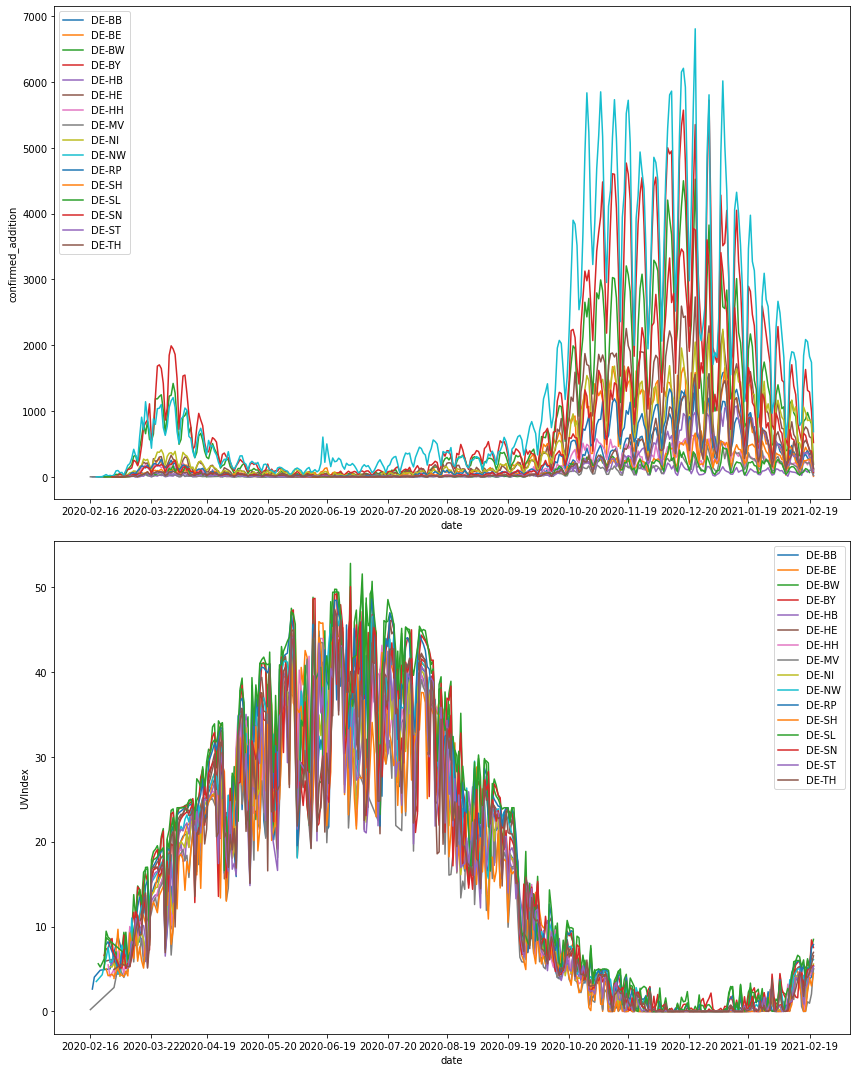

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,15))

for m,n in zip(masks, range(16)):
    sns.lineplot(x= region_per_day["date"], y=region_per_day["confirmed_addition"][m], ax=axes[0], label=regions[n])
    sns.lineplot(x=region_per_day["date"], y=region_per_day["UVIndex"][m], ax=axes[1], label=regions[n])

axes[0].legend(loc="upper left")
axes[1].legend(loc="upper right")

axes[0].xaxis.set_major_locator(mdates.MonthLocator())
axes[1].xaxis.set_major_locator(mdates.MonthLocator())

plt.tight_layout()

#### Weekly data visualization

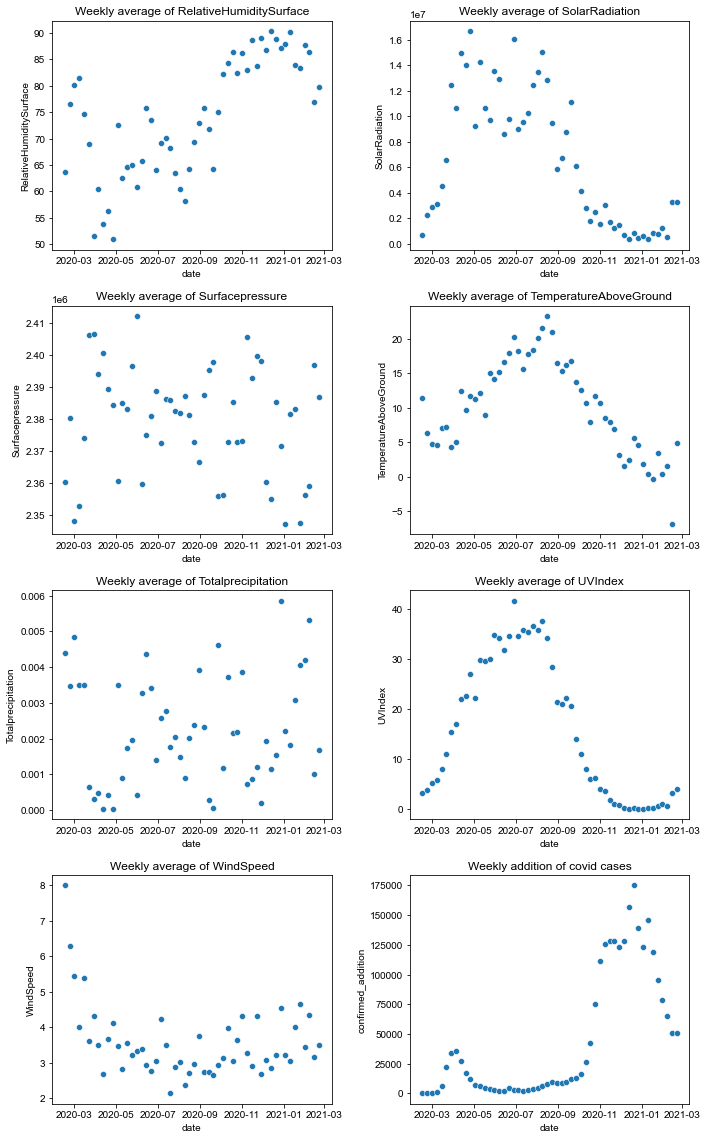

In [31]:
# plot subplots
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (10, 16))

# make a list off the different predicters to reference later
preds = features.copy()
preds.append('confirmed_addition')

# create plots
sns.set()
for ax, i in zip(axes.flat, range(8)):
    ind = preds[i]
    sns.scatterplot(x = data_per_week['date'], y = data_per_week[ind], ax = ax)
    if ind != "confirmed_addition":
        ax.set_title(f"Weekly average of {ind}")
    else:
        ax.set_title("Weekly addition of covid cases")

plt.tight_layout()

#### Monthly data visualization

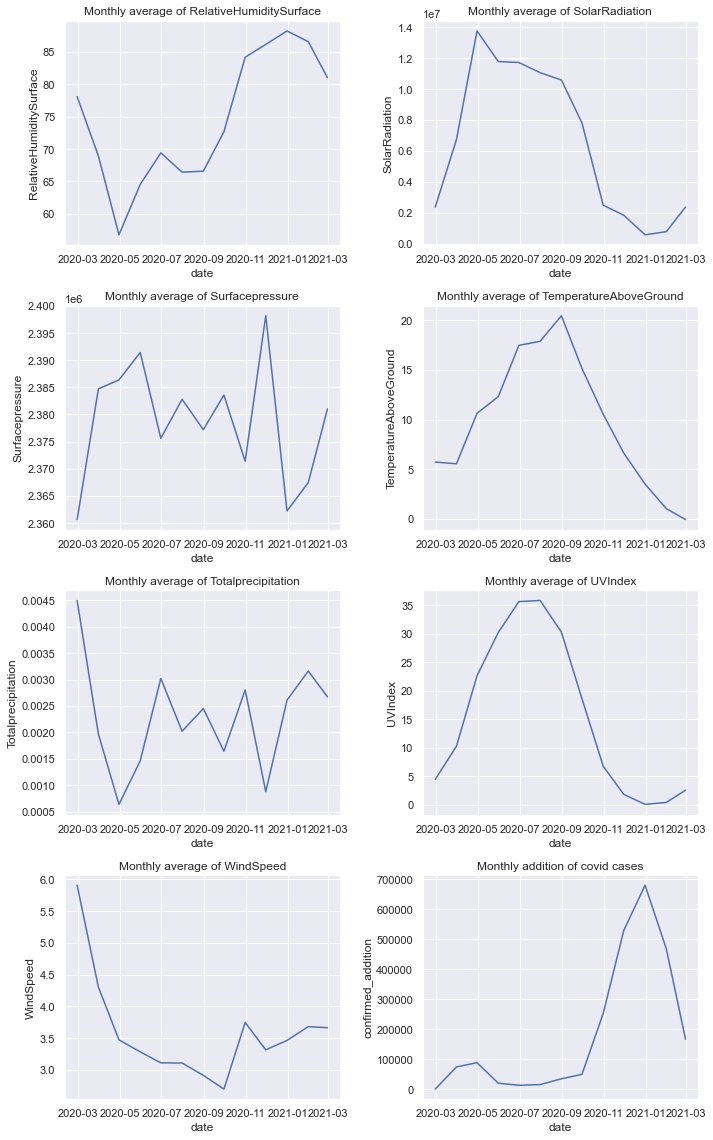

In [32]:
# plot the data by month, same procedure as above
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (10, 16))

sns.set()
for ax, i in zip(axes.flat, range(8)):
    ind = preds[i]
    sns.lineplot(x = data_per_month['date'], y = data_per_month[ind], ax = ax)
    if ind != "confirmed_addition":
        ax.set_title(f"Monthly average of {ind}")
    else: 
        ax.set_title("Monthly addition of covid cases")

plt.tight_layout()

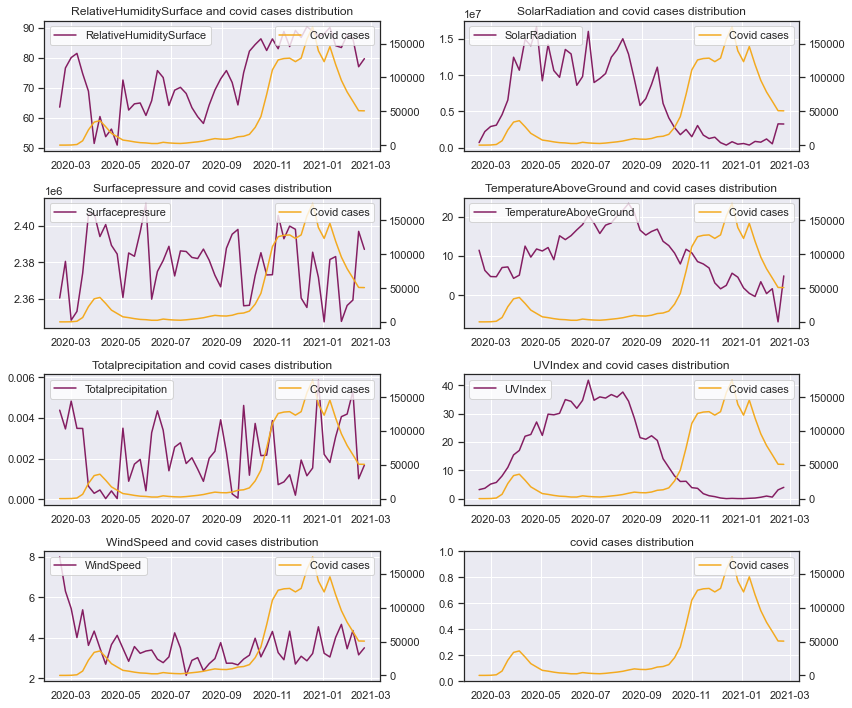

In [33]:
# create subplots that plot covid cases against the features identified through pearson
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (12, 10))

sns.set()
sns.set_style('ticks')
for ax, i in zip(axes.flat, range(8)):
    ind = preds[i]
    if ind != "confirmed_addition":
        ax.plot(data_per_week['date'], data_per_week[ind], label = ind, color = '#841e62')
        ax.legend(loc = 'upper left')
        ax.set_title(f'{ind} and covid cases distribution')
    else:
        ax.set_title("covid cases distribution")
    twin = ax.twinx()
    twin.plot(data_per_week['date'], data_per_week['confirmed_addition'], label = 'Covid cases', color = '#f3aa20')
    twin.legend(loc = 'upper right') 
    
plt.tight_layout()

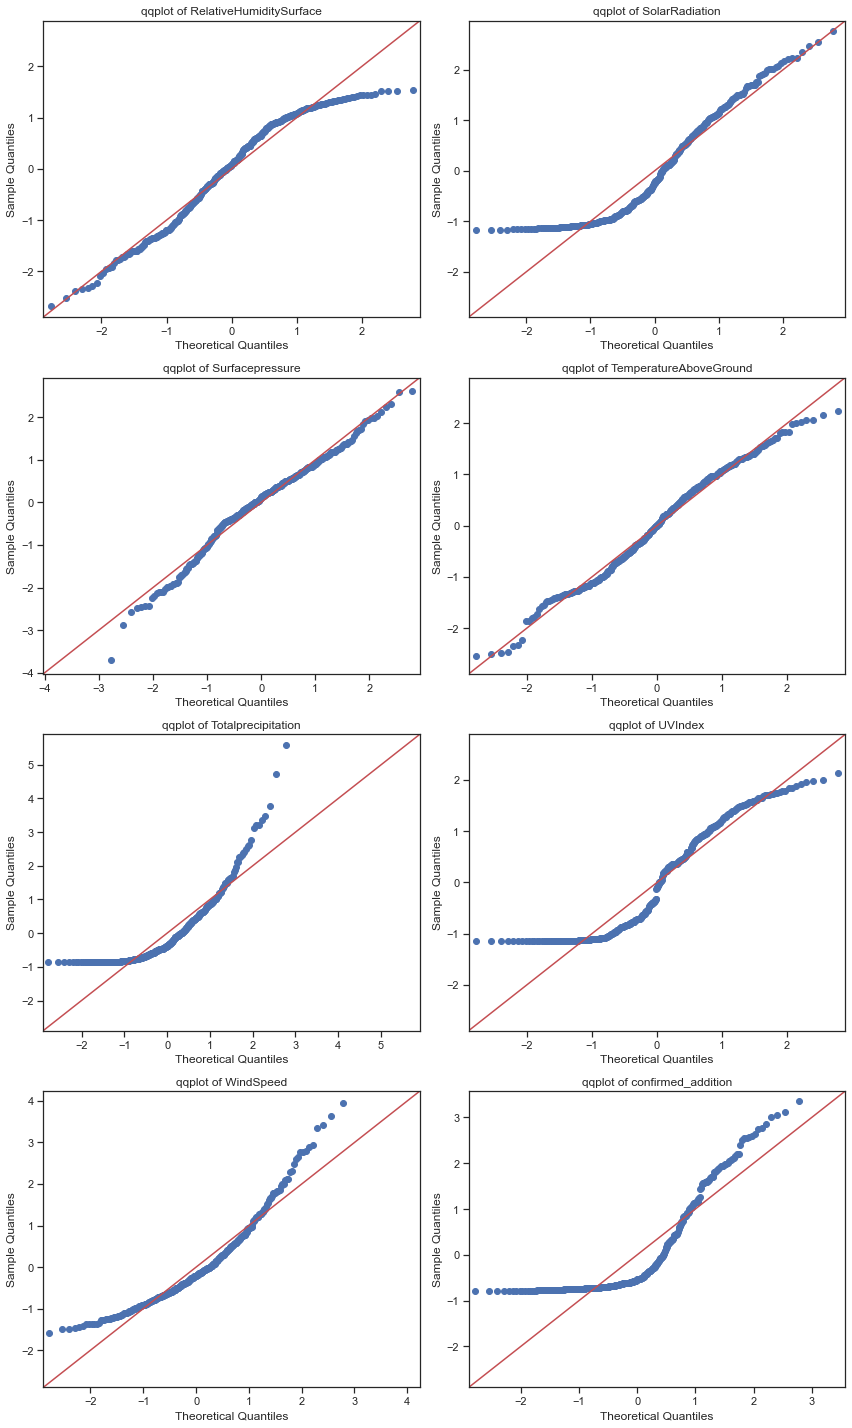

In [34]:
# using qqplot to understand if the features follow a normal distribution. If they do not, then using Spearman would make more sense 
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (12, 20))

sns.set()
for ax, i in zip(axes.flat, range(8)):
    ind = preds[i]
    sm.qqplot(data_per_day[ind], fit = True, line = '45', ax = ax)
    ax.set_title(f'qqplot of {ind}')

plt.tight_layout()

#### Numerical analysis of the data

In [35]:
# getting a numerical summary of the different attributes
weather_data.describe()

,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
count,6000.000000,6.000000e+03,6.000000e+03,6000.000000,6000.000000,6000.000000,6000.000000
mean,74.332120,6.678336e+06,2.379588e+06,10.131258,0.002206,16.050800,3.503221
std,13.595421,6.212940e+06,5.121144e+04,7.146610,0.003439,14.515517,1.438837
min,33.880265,0.000000e+00,2.212828e+06,-12.618286,0.000000,0.000000,1.091346
25%,64.268213,1.090176e+06,2.343795e+06,4.687390,0.000054,2.500231,2.427226
50%,76.469758,4.610296e+06,2.385826e+06,10.078646,0.000684,12.720154,3.202055
75%,85.703146,1.150929e+07,2.422283e+06,15.722994,0.002907,27.398392,4.261427
max,98.264247,2.370823e+07,2.497243e+06,27.810922,0.031971,52.792235,11.221876


### Task 2: Associations

#### Visualization

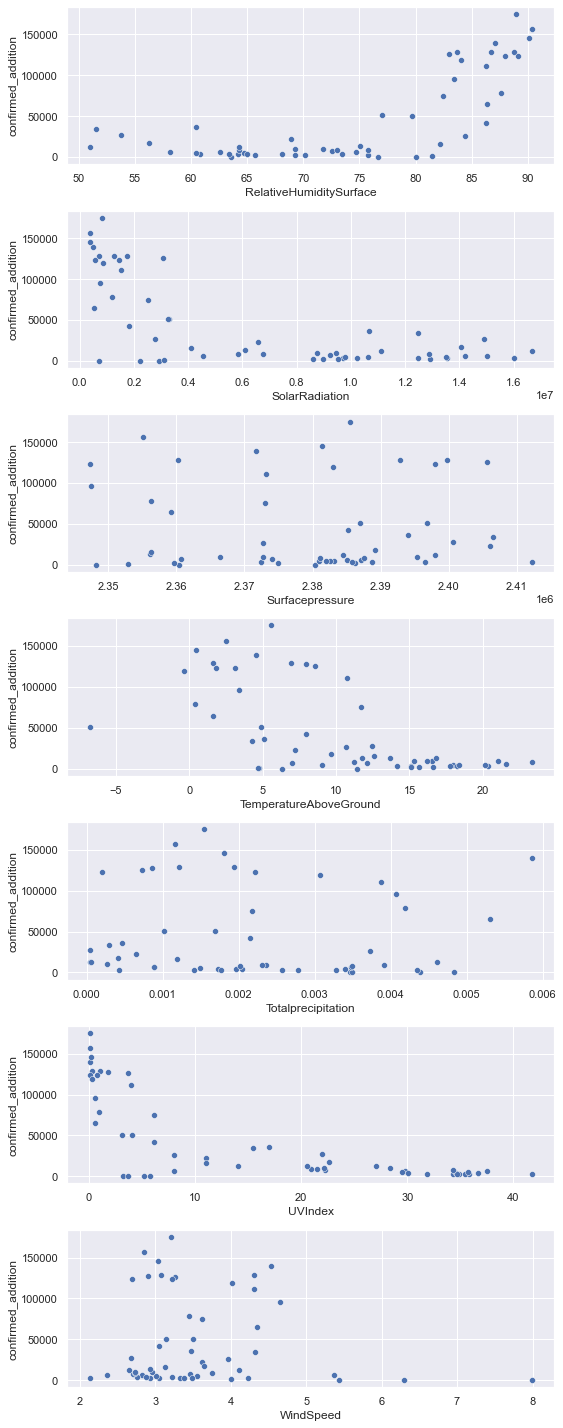

In [36]:
#plot the weather variables against the corona cases to see if there is any visual correlation
fig, axes = plt.subplots(nrows=7, ncols=1, figsize= (8,20))

feats = features.copy()

sns.set_style("ticks")
for ax, i in zip(axes.flat, range(7)):
    ind = feats[i]
    sns.scatterplot(x=data_per_week[ind], y=data_per_week["confirmed_addition"], ax=ax)
    
plt.tight_layout()

#you can see a correlation between some of the variables and covid cases
#but visuals are not reliable so we do actual calculations in the next step

In [37]:
# running pearson, spearman, and log transformed pearson with the bonferroni correction 

# analysing the features with pearson printing those with p-value under significance threshold
significance_threshold = .005
features_pear = []
for var in region_per_day.columns[5:]:
    corr, pvalue = pearsonr(region_per_day['confirmed_addition'], region_per_day[var])
    # print(f'{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold}\n')
    if np.abs(corr) > .3 and pvalue < significance_threshold:
        features_pear.append(var)
print(f'The relevant features according to pearson correlation are {features_pear}')

# analysing the features with spearman 
features_spear = []
for var in region_per_day.columns[5:]:
     corr, pvalue = spearmanr(region_per_day['confirmed_addition'], region_per_day[var])
     # print(f'{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold}\n')
     if np.abs(corr) > .3 and pvalue < significance_threshold:
         features_spear.append(var)
print(f'The relevant features according to spearman correlation are {features_spear}')

# analysing the features with log transformed pearson 
features_log_pear = []
for var in region_per_day.columns[5:]:
    corr, pvalue = pearsonr(np.log(region_per_day['confirmed_addition']+1), region_per_day[var])
    # print(f'{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold}\n')
    if np.abs(corr) > .3 and pvalue < significance_threshold:
        features_log_pear.append(var)

print(f'The relevant features according to log transformed pearson correlation are {features_log_pear}')
#we cannot use these correlations because we cannot assume that the features are independent 

The relevant features according to pearson correlation are ['cases_pc', 'RelativeHumiditySurface', 'SolarRadiation', 'TemperatureAboveGround', 'UVIndex']
The relevant features according to spearman correlation are ['cases_pc', 'RelativeHumiditySurface', 'SolarRadiation', 'TemperatureAboveGround', 'UVIndex']
The relevant features according to log transformed pearson correlation are ['cases_pc', 'RelativeHumiditySurface', 'SolarRadiation', 'TemperatureAboveGround', 'UVIndex']


In [38]:
# bonferroni correction (this is still under the assumption that they are independent)
significance_threshold_bonf = .005 / (len(features) * 3)

# Linear
print('Linear')
for var in features:
    corr, pvalue = pearsonr(region_per_day['confirmed_addition'], region_per_day[var])
    print(f'{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold_bonf}\n')

# Spearman
print('Spearman')
for var in features:
    corr, pvalue = spearmanr(region_per_day['confirmed_addition'], region_per_day[var])
    print(f'{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold_bonf}\n')

# Log
print('Log')
for var in features:
    corr, pvalue = pearsonr(np.log(region_per_day['confirmed_addition'] + 1), region_per_day[var])
    print(f'{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold_bonf}\n')

Linear
RelativeHumiditySurface
0.343	1.6645350728489173e-153	True

SolarRadiation
-0.346	4.9463537017080786e-157	True

Surfacepressure
-0.254	3.724268829474388e-83	True

TemperatureAboveGround
-0.364	2.2266597734603486e-174	True

Totalprecipitation
0.046	0.000575785884169454	False

UVIndex
-0.424	6.229321949141467e-243	True

WindSpeed
-0.033	0.0125469030820965	False

Spearman
RelativeHumiditySurface
0.468	7.510592264687039e-302	True

SolarRadiation
-0.516	0.0	True

Surfacepressure
-0.239	4.681330884969123e-73	True

TemperatureAboveGround
-0.578	0.0	True

Totalprecipitation
0.072	6.176316724575035e-08	True

UVIndex
-0.655	0.0	True

WindSpeed
-0.014	0.29525564389645925	False

Log
RelativeHumiditySurface
0.422	1.5716060440387838e-239	True

SolarRadiation
-0.469	1.4038896095940713e-303	True

Surfacepressure
-0.251	1.0650823309103934e-80	True

TemperatureAboveGround
-0.550	0.0	True

Totalprecipitation
0.022	0.09897196360742602	False

UVIndex
-0.623	0.0	True

WindSpeed
-0.017	0.2149067812046

In [39]:
# holm bonferroni 
# store all of the p-values in a list
pvalues = []
tests = ('linear', 'spearman', 'log')

for var in features:
    corr, pvalue = pearsonr(region_per_day['confirmed_addition'], region_per_day[var])
    pvalues.append(pvalue)

for var in features:
    corr, pvalue = spearmanr(region_per_day['confirmed_addition'], region_per_day[var])
    pvalues.append(pvalue)

for var in features:
    corr, pvalue = pearsonr(np.log(region_per_day['confirmed_addition'] + 1), region_per_day[var])
    pvalues.append(pvalue)

#running multiple tests with the p-values we got above
significant, pholmcorrected, _, _ = multipletests(pvalues, alpha = .005, method = 'holm')
for i in range(len(significant)):
    print(f'{tests[i // len(features)]}\t{features[i % len(features)]}\t{significant[i]}')

linear	RelativeHumiditySurface	True
linear	SolarRadiation	True
linear	Surfacepressure	True
linear	TemperatureAboveGround	True
linear	Totalprecipitation	True
linear	UVIndex	True
linear	WindSpeed	False
spearman	RelativeHumiditySurface	True
spearman	SolarRadiation	True
spearman	Surfacepressure	True
spearman	TemperatureAboveGround	True
spearman	Totalprecipitation	True
spearman	UVIndex	True
spearman	WindSpeed	False
log	RelativeHumiditySurface	True
log	SolarRadiation	True
log	Surfacepressure	True
log	TemperatureAboveGround	True
log	Totalprecipitation	False
log	UVIndex	True
log	WindSpeed	False


#### Multivariate regression


In [40]:
# creating a constant variable to calculate the intercept 
corona = sm.add_constant(corona)
features.append('const')

# linear multivariate regression
lmr = sm.OLS(corona['confirmed_addition'], corona[features], hasconst = True).fit()
print(lmr.summary())

                            OLS Regression Results                            
Dep. Variable:     confirmed_addition   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     283.5
Date:                Mon, 01 Aug 2022   Prob (F-statistic):               0.00
Time:                        12:46:32   Log-Likelihood:                -44588.
No. Observations:                5580   AIC:                         8.919e+04
Df Residuals:                    5572   BIC:                         8.925e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

In [41]:
# log transformation of the above 
# 1 is added to the log to avoid error when taking the log of 0
lg_lmr = sm.OLS(np.log(corona['confirmed_addition'] + 1), corona[features], hasconst = True).fit()
print(lg_lmr.summary())

# the first lmr has an r-squared of 0.263 and after log-transforming we get a r-squared of 0.491
# i.e. this model is more meaningful

                            OLS Regression Results                            
Dep. Variable:     confirmed_addition   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     768.9
Date:                Mon, 01 Aug 2022   Prob (F-statistic):               0.00
Time:                        12:46:32   Log-Likelihood:                -9866.2
No. Observations:                5580   AIC:                         1.975e+04
Df Residuals:                    5572   BIC:                         1.980e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

In [42]:
# Select Features
corona = sm.add_constant(corona)
Xs = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround', 'Totalprecipitation', 'UVIndex', 'WindSpeed']
Xs.append('const')

In [43]:
# Run the linear multivariate regression for cases per capita
est = sm.OLS(np.log(corona['cases_pc'] + 1), corona[Xs], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               cases_pc   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     531.7
Date:                Mon, 01 Aug 2022   Prob (F-statistic):               0.00
Time:                        12:46:32   Log-Likelihood:                 44119.
No. Observations:                5580   AIC:                        -8.822e+04
Df Residuals:                    5572   BIC:                        -8.817e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface  1

In [44]:
# adding a dummy variable that absorbs every possible omitted variable that distinguishes a region from all other regions.
regions = ['const',]

for region in set(corona['iso3166-2']):
    if region != 'DE-SN':
        corona[region] = (corona['iso3166-2'] == region).astype(int)
        regions.append(region)
        Xs.append(region)

In [45]:
# linear multivariate regression with the cases per capita 
est = sm.OLS(np.log(corona['cases_pc'] + 1), corona[regions], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               cases_pc   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     13.01
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           8.63e-33
Time:                        12:46:32   Log-Likelihood:                 42788.
No. Observations:                5580   AIC:                        -8.554e+04
Df Residuals:                    5564   BIC:                        -8.544e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001    6.1e-06     22.232      0.0

In [46]:
est = sm.OLS(np.log(corona['cases_pc'] + 1), corona[Xs], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               cases_pc   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     204.2
Date:                Mon, 01 Aug 2022   Prob (F-statistic):               0.00
Time:                        12:46:32   Log-Likelihood:                 44344.
No. Observations:                5580   AIC:                        -8.864e+04
Df Residuals:                    5557   BIC:                        -8.849e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface  2

In [47]:
# Repeat linear regression using Clustered standard error
est = sm.OLS(np.log(corona['cases_pc'] + 1), corona[Xs], hasconst = True).fit(cov_type = 'cluster', cov_kwds = {'groups': corona['iso3166-2']}, use_t = True)
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               cases_pc   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                 2.274e+04
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           4.98e-29
Time:                        12:46:32   Log-Likelihood:                 44344.
No. Observations:                5580   AIC:                        -8.864e+04
Df Residuals:                    5557   BIC:                        -8.849e+04
Df Model:                          22                                         
Covariance Type:              cluster                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface  2

C:\Users\germa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 22, but rank is 7
  warnings.warn('covariance of constraints does not have full '


### Task 3: Maps

In [48]:
# creating a map of germany using folium, adding the corona data per region, creating an orange-red scale to visualise the cases
cases_map = folium.Map(location = [51.1657, 10.4515], zoom_start = 5) 
folium.Choropleth(geo_data = geojsonpath, 
name = 'cases', 
data = corona_data_by_region,
columns = ['region', 'confirmed_addition'],
key_on = 'properties.iso_3166_2',
fill_color = 'OrRd',
fill_opacity = .7,
line_opacity = .2,
legend_name = 'total cases',
).add_to(cases_map)
cases_map

In [49]:
# creating another map to show the cases per capita in the different regions of germany 
casespc_map = folium.Map(location = [51.1657, 10.4515], zoom_start = 5) # creating another map of Germany
folium.Choropleth(geo_data = geojsonpath, 
name = 'cases',
data = corona_data_by_region,
columns = ['region', 'casesPercentage'],
key_on = 'properties.iso_3166_2',
fill_color = 'OrRd',
fill_opacity = .7,
line_opacity = .2,
legend_name = 'cases per 100 people',
).add_to(casespc_map)
casespc_map

### Task 4: Open question

In [50]:
# Load the external data set containing the stringency index
stringency_Index = oxfordpath
str_data = pd.read_csv(stringency_Index, sep = ',', low_memory = False)

# create a list with the columns we want from the dataset
var = ['Date', 'C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events', 'C4_Restrictions on gatherings', 'C5_Close public transport',
           'C6_Stay at home requirements', 'C7_Restrictions on internal movement', 'C8_International travel controls']

# sort the data to only contain germany
de_str = str_data[str_data['CountryName'] == 'Germany'][var]

# formatting the date
de_str['date'] = de_str['Date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:8])

# Dropping old unformatted date column
de_str = de_str.drop('Date', axis=1).dropna()

# adding a lag of ten days to the data
de_str['date'] = pd.to_datetime(de_str['date'], format = '%Y-%m-%d') + timedelta(days = 10)

# Putting the date as the first column   ASK ABOUT THIS
de_str = (de_str.set_index('date') > 0).astype(int).reset_index()

# Changing 'date' back to a string from datetime64, making it possible to merge on date  
de_str['date'] = de_str['date'].dt.strftime('%Y-%m-%d')

# merging the stringency index with our corona data
corona_str = corona_data.merge(de_str, on = 'date')


In [51]:
# adding a constant to the dataframe, appending a constant to the list of predictives
corona_str = sm.add_constant(corona_str)
var = var[1:] # because the first column is the date
var.append('const')

# same as before, using one region as a dummy variable
for region in set(corona_str['region_code']):
    if region != 'Berlin':
        corona_str[region]= (corona_str['region_code']==region).astype(int)
        var.append(region)

# running the ordinary least squares regression with the cases per capita and the stringency index
lmr_str = sm.OLS(np.log(corona_str['cases_pc']+1), corona_str[var], hasconst=True).fit(cov_type = 'cluster', cov_kwds= {'groups': corona_str['region_code']}, use_t=True)
print(lmr_str.summary())

# the p-values are fine but the coefficients are small, the test therefore does not show a big correlation between restrictions and cases
# the results are not statistically significant
#as a whole, the restrictions have an impact but independently there is not a big correlation

                            OLS Regression Results                            
Dep. Variable:               cases_pc   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     67.95
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           2.17e-10
Time:                        12:46:36   Log-Likelihood:                 44383.
No. Observations:                5599   AIC:                        -8.872e+04
Df Residuals:                    5575   BIC:                        -8.856e+04
Df Model:                          23                                         
Covariance Type:              cluster                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


C:\Users\germa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 8
  warnings.warn('covariance of constraints does not have full '
